# Introduction to dynamic AFM simulations
###### Content under Creative Commons Attribution license CC-BY 4.0 version, 
#### Enrique A. López-Guerra.

Purpose of the notebook: show an application of numerical methods to simulate the dynamics of a probe in atomic force microscopy.

Requirements to take the best advantage of this notebook: knowing the fundamentals of  [Harmonic Oscillators](http://en.wikipedia.org/wiki/Harmonic_oscillsator) in clasical mechanics and [Fundamentals of Vibrations](http://en.wikipedia.org/wiki/Vibration). 

## Introduction

Since the atomic force microscope (AFM) was invented in 1986 it has become one of the main tools to study matter at the micro and nanoscale. This powerful tool is so versatile that it can be used to study a wide variety of materials, ranging from stiff inorganic surfaces to soft biological samples. 

In its early stages the AFM was used in permanent contact with the sample (the probe is dragged over the sample during the whole operation), which brought about important drawbacks, such as rapid probe wear and often sample damage, but these obstacles have been overcome with the development of dynamic techniques.

In this Jupyter notebook, we will focus on the operation of the probe in dynamic mode.

In [1]:
from __future__ import division, print_function, absolute_import, unicode_literals
import os
import numpy
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image

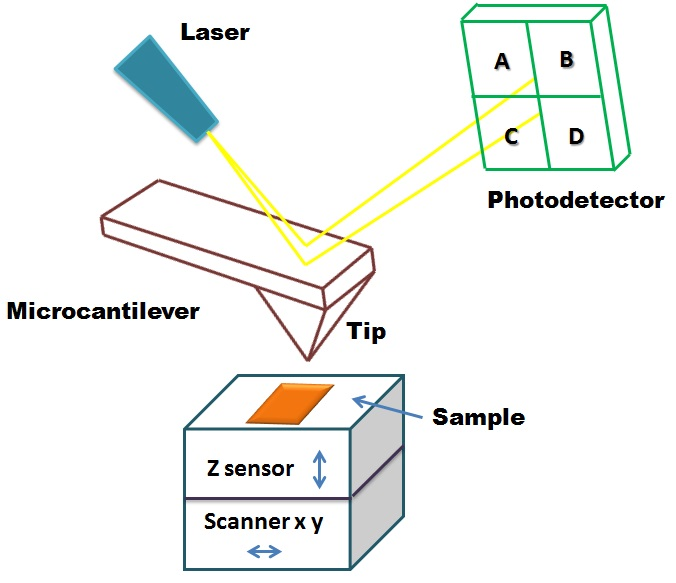

In [2]:
path = os.getcwd()
fig1 = path + '/Fig1.jpg'
Image(filename=fig1)

#### Figure 1.   Schematics of the setup of a atomic force microscope (Adapted from reference 6)

In AFM the interacting probe is in general a rectangular cantilever (please check the image above that shows the AFM setup where you will be able to see the probe!). 
Probably the most used dynamic technique in AFM is the Tapping Mode. In this method the probe taps a surface in intermittent contact fashion. The purpose of tapping the probe over the surface instead of dragging it is to reduce frictional forces that may cause damage of soft samples and wear of the tip. Besides with the tapping mode we can get more information about the sample!  HOW???

In Tapping Mode AFM the cantilever is shaken to oscillate up and down at a specific frequency (most of the time shaken at its natural frequency). Then the deflection of the tip is measured at that frequency to get information about the sample. Besides acquiring the topography of the sample, the phase lag between the excitation and the response of the cantilever can be related to compositional material properties! 
In other words one can simultaneously get information about how the surface looks and also get compositional mapping of the surface!  THAT SOUNDS POWERFUL!!!

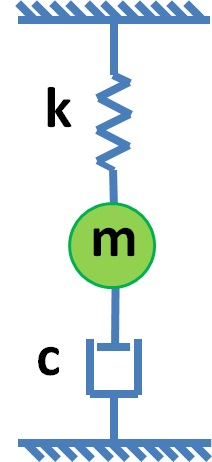

In [3]:
fig2 = path + '/Fig2DHO.jpg'
Image(filename=fig2)

#### Figure 2. Schematics of a damped harmonic oscillator without tip-sample interactions

## Analytical Solution

The motion of the probe can be derived using [Euler-Bernoulli's](http://en.wikipedia.org/wiki/Euler%E2%80%93Bernoulli_beam_theory) equation. However that equation has partial derivatives (it depends on time and space) because it deals with finding the position of each point of the beam in a certain time, which cant make the problem too expensive computationally for our purposes. In our case, we have the advantage that we are only concerned about the position of the tip (which is the only part of the probe that will interact with the sample). As a consequence many researchers in AFM have successfully made approximations using a simple mass point model approximation [see ref. 2] like the one in figure 2 (with of course the addition of tip sample forces!  We will see more about this later).

First we will study the system of figure 2 AS IS (without addition of tip-sample force term), WHY?  Because we want to get an analytical solution to get a reference of how our integration schemes are working, and the addition of tip sample forces to our equation will prevent the acquisition of straightforward analytical solutions :(

Then, the equation of motion of the damped harmonic oscillator of figure 2, which is DRIVEN COSINUSOIDALLY (remember that we are exciting our probe during the scanning process) is:

$$\begin{equation}
m \frac{d^2z}{dt^2} = - k z - \frac{m\omega_0}{Q}\frac{dz}{dt} + F_0\cos(\omega t)
\end{equation}$$
where k is the stiffness of the cantilever, z is the vertical position of the tip with respect to the cantilever base position, Q is the quality factor (which is related to the damping of the system), $F_0$ is the driving force amplitude, $\omega_0$ is the resonance frequency of the oscillator, and $\omega$ is the frequency of the oscillating force.

The analytical solution of the above ODE is composed by a transient term and a steady state term. We are only interested in the steady state part because during the scanning process it is assumed that the probe has achieved that state.

The steady state solution is given by:
$$\begin{equation}
A\cos (\omega t - \phi)
\end{equation}$$

where A is the steady state amplitude of the oscillation response, which depends on the cantilever parameters and the driving parameters, as can be seen in the following relation:
$$\begin{equation}
A = \frac{F_0/m}{\sqrt{(\omega_0^2-\omega^2)^2+(\frac{\omega\omega_0}{Q})^2}}
\end{equation}$$

and $\phi$ is given by:
$$\begin{equation}
\phi = \arctan \big( \frac{\omega\omega_0/Q}{\omega_0^2 - \omega^2} \big)
\end{equation}$$


Let's first name the variables that we are going to use. Because we are dealing with a damped harmonic oscillator model we have to include variables such as: spring stiffness, resonance frequency, quality factor (related to damping coefficient), target oscillation amplitude, etc.

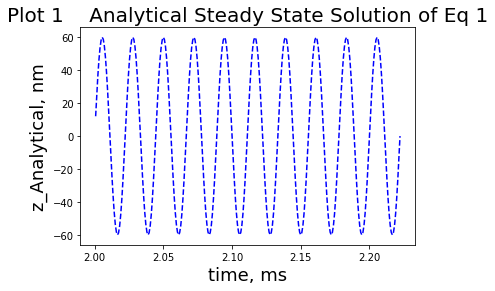

In [4]:
k = 10.
fo = 45000
wo = 2.0*numpy.pi*fo
Q = 25.

period = 1./fo
m = k/(wo**2)
Ao = 60.e-9
Fd = k*Ao/Q

spp = 28. # time steps per period 
dt = period/spp #Intentionally chosen to be quite big
#you can decrease dt by increasing the number of steps per period

simultime = 100.*period
N = int(simultime/dt)

#Analytical solution

time_an = numpy.linspace(0,simultime,N)  #time array for the analytical solution
z_an = numpy.zeros(N)  #position array for the analytical solution

#Driving force amplitude this gives us 60nm of amp response (A_target*k/Q)
Fo_an = 24.0e-9  

A_an = Fo_an*Q/k  #when driven at resonance A is simply Fo*Q/k
phi = numpy.pi/2  #when driven at resonance the phase is pi/2

z_an[:] = A_an*numpy.cos(wo*time_an[:] - phi) #this gets the analytical solution

#slicing the array to include only steady state (only the last 10 periods)
z_an_steady = z_an[int(90.*period/dt):]
time_an_steady = time_an[int(90.*period/dt):]

plt.title('Plot 1    Analytical Steady State Solution of Eq 1', fontsize=20)
plt.xlabel('time, ms', fontsize=18)
plt.ylabel('z_Analytical, nm', fontsize=18)
plt.plot(time_an_steady*1e3, z_an_steady*1e9, 'b--')


### Approximating through Euler's method

If we perform a Taylor series expansion of $z_{n+1}$ around $z_{n}$ we get:

$$z_{n+1} = z_{n} + \Delta t\frac{dz}{dt}\big|_n + {\mathcal O}(\Delta t^2)$$

The Euler formula neglects terms in the order of two or higher, ending up as:

$$\begin{equation}
z_{n+1} = z_{n} + \Delta t\frac{dz}{dt}\big|_n
\end{equation}$$

It can be easily seen that the truncation error of the Euler algorithm is in the order of ${\mathcal O}(\Delta t^2)$.






This is a second order ODE, but we can convert it to a system of two coupled 1st order differential equations. To do it we will define $\frac{dz}{dt} = v$. Then equation (1) will be decomposed as:
$$\begin{equation}
\frac{dz}{dt} = v
\end{equation}$$

$$\begin{equation}
\frac{dv}{dt} = -kz-\frac{m\omega_0}{Q}+F_o\cos(\omega t)
\end{equation}$$

These coupled equations will be used during Euler's aproximation and also during our integration using Runge Kutta 4 method.

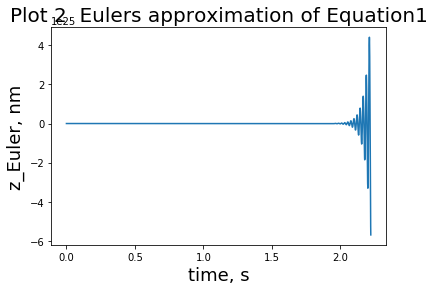

In [5]:
t= numpy.linspace(0,simultime,N) #time grid for Euler method
    
#Initializing variables for Euler
vdot_E = numpy.zeros(N)
v_E = numpy.zeros(N)
z_E = numpy.zeros(N)

#Initial conditions
z_E[0]= 0.0
v_E[0]=0.0

for i in range (N-1):
    vdot_E[i] =( ( -k*z_E[i] - (m*wo/Q)*(v_E[i])   +\
                    Fd*numpy.cos(wo*t[i]) ) / m)  #Equation 7
    v_E[i+1] = v_E[i] + dt*vdot_E[i]  #Based on equation 5
    z_E[i+1] = z_E[i] + v_E[i]*dt  #Equation 5

plt.title('Plot 2  Eulers approximation of Equation1', fontsize=20);        
plt.plot(t*1e3,z_E*1e9);
plt.xlabel('time, s', fontsize=18);
plt.ylabel('z_Euler, nm', fontsize=18);


This looks totally unphysical! We were expecting to have a steady state oscillation of 60 nm and we got a huge oscillation that keeps growing. Can it be due to the scheme? The timestep that we have chosen is quite big with respect to the oscillation period. We have intentionally set it to ONLY 28 time steps per period (That could be the reason why the scheme can't capture the physics of the problem). That's quite discouraging. However the timestep is quite big and it really gets better as you decrease the time step. Try it! Reduce the time step and see how the numerical solution acquires an amplitude of 60 nm as the analytical one. At this point we can't state anything about accuracy before doing an analysis of error (we will make this soon). But first, let's try to analyze if another more efficient scheme can capture the physics of our damped harmonic oscillator even with this large time step.

### Let's try to get more accurate... Verlet Algorithm

This is a very popular algorithm widely used in molecular dynamics simulations. Its popularity has been related to high stability when compared to the simple Euler method, it is also very simple to implement and accurate as we will see soon!  Verlet integration can be seen as using the central difference approximation to the second derivative. Consider the Taylor expansion of $z_{n+1}$ and $z_{n-1}$ around $z_n$:

$$\begin{equation}
z_{n+1} = z_n + \Delta t \frac{dz}{dt}\big|_n + \frac{\Delta t^2}{2} \frac{d^2 z}{d t^2}\big|_n + \frac{\Delta t^3}{6} \frac{d^3 z}{d t^3}\big|_n + {\mathcal O}(\Delta t^4)
\end{equation}$$

$$\begin{equation}
z_{n-1} = z_n - \Delta t \frac{dz}{dt}\big|_n + \frac{\Delta t^2}{2} \frac{d^2 z}{dt^2}\big|_n - \frac{\Delta t^3}{6} 
\frac{d^3 z}{d t^3}\big|_n + {\mathcal O}(\Delta t^4)
\end{equation}$$

Adding up these two expansions and solving for $z_{n+1}$ we get:

$$z_{n+1}= 2z_{n} - z_{n-1} + \frac{d^2 z}{d t^2} \Delta t^2\big|_n + {\mathcal O}(\Delta t^4) $$

Verlet algorithm neglects terms on the order of 4 or higher, ending up with:

$$\begin{equation}
z_{n+1}= 2z_{n} - z_{n-1} + \frac{d^2 z}{d t^2} \Delta t^2\big|_n
\end{equation}$$


This looks nice; it seems that the straightforward calculation of the second derivative will give us good results. BUT have you seen that we also need the value of the first derivative (velocity) to put it into the equation of motion that we are integrating (see equation 1). YES, that's a main drawback of this scheme and therefore it's mainly used in applications where the equation to be integrated doesn't have first derivative. But don't panic we will see what can we do...

What about subtracting equations 8 and 9 and then solving for $\frac{dz}{dt}\big|_n$:
$$
\frac{dz}{dt}\big|_n =  \frac{z_{n+1} - z_{n-1}}{2\Delta t} + {\mathcal O}(\Delta t^2)
$$
If we neglect terms on the order of 2 or higher we can calculate velocity:
$$\begin{equation}
\frac{dz}{dt}\big|_n =  \frac{z_{n+1} - z_{n-1}}{2\Delta t}
\end{equation}$$

This way of calculating velocity is pretty common in Verlet integration in applications where velocity is not explicit in the equation of motion. However for our purposes of solving equation 1 (where first derivative is explicitly present) it seems that we will lose accuracy because of the velocity, we will discuss more about this soon after...

Have you noticed that we need a value $z_{n-1}$? Does it sound familiar?  YES!  This is not a self-starting method. As a result we will have to overcome the issue by setting the initial conditions of the first step using Euler approximation. This is a bit annoying, but a couple of extra lines of code won't kill you :)

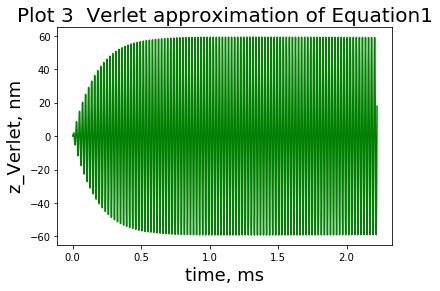

In [6]:
time_V = numpy.linspace(0,simultime,N)

#Initializing variables for Verlet
zdoubledot_V = numpy.zeros(N)
zdot_V = numpy.zeros(N)
z_V = numpy.zeros(N)

#Initial conditions Verlet. Look how we use Euler for the first step approximation!
z_V[0] = 0.0
zdot_V[0] = 0.0
zdoubledot_V[0] = (   ( -k*z_V[0] - (m*wo/Q)*zdot_V[0] +\
                            Fd*numpy.cos(wo*t[0]) )  ) / m
zdot_V[1] = zdot_V[0] + zdoubledot_V[0]*dt
z_V[1] = z_V[0] + zdot_V[0]*dt
zdoubledot_V[1] = (   ( -k*z_V[1] - (m*wo/Q)*zdot_V[1] +\
                            Fd*numpy.cos(wo*t[1]) )  ) / m

#VERLET ALGORITHM

for i in range(2,N):
    z_V[i] = 2*z_V[i-1] - z_V[i-2] + zdoubledot_V[i-1]*dt**2 #Eq 10
    zdot_V[i] = (z_V[i]-z_V[i-2])/(2.0*dt) #Eq 11
    zdoubledot_V[i] = (   ( -k*z_V[i] - (m*wo/Q)*zdot_V[i] +\
                               Fd*numpy.cos(wo*t[i]) )  ) / m #from eq 1
    
plt.title('Plot 3  Verlet approximation of Equation1', fontsize=20); 
plt.xlabel('time, ms', fontsize=18);
plt.ylabel('z_Verlet, nm', fontsize=18);
plt.plot(time_V*1e3, z_V*1e9, 'g-');
plt.ylim(-65,65);
 


It WAS ABLE to capture the physics! Even with the big time step that we use with Euler scheme!

As you can see, and as we previously discussed the harmonic response is composed of a transient and a steady part. We are only concerned about the steady-state, since it is assumed that the probe achieves steady state motion during the imaging process. Therefore, we are going to slice our array in order to show only the last 10 oscillations, and we will see if it resembles the analytical solution.

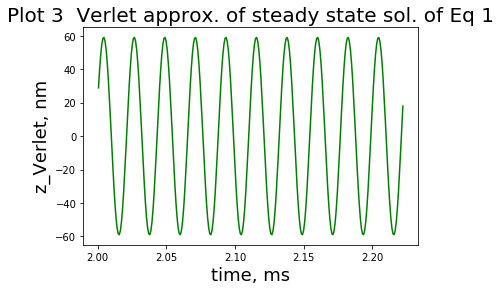

In [7]:
#Slicing the full response vector to get the steady state response
z_steady_V = z_V[int(90*period/dt):]
time_steady_V = time_V[int(90*period/dt):]

plt.title('Plot 3  Verlet approx. of steady state sol. of Eq 1', fontsize=20); 
plt.xlabel('time, ms', fontsize=18);
plt.ylabel('z_Verlet, nm', fontsize=18);
plt.plot(time_steady_V*1e3, z_steady_V*1e9, 'g-');
plt.ylim(-65,65);
plt.show();


### Let's use now one of the most popular schemes...     The Runge Kutta 4!

The Runge Kutta 4 (RK4) method is very popular for the solution of ODEs. This method is designed to solve 1st order differential equations. We have converted our 2nd order ODE to a system of two coupled 1st order ODEs when we implemented the Euler scheme (equations 5 and 6). And we will  have to use these equations for the RK4 algorithm.

In order to clearly see the RK4 implementation we are going to put equations 5 and 6 in the following form:
$$\begin{equation}
\frac{dz}{dt}=v \Rightarrow f1(t,z,v)
\end{equation}$$
$$\begin{equation}
\frac{dv}{dt} = -kz-\frac{m\omega_0}{Q}+F_ocos(\omega t) \Rightarrow f2(t,z,v)
\end{equation}$$

It can be clearly seen that we have two coupled equations f1 and f2 and both depend in t, z, and v.

The RK4 equations for our special case where we have two coupled equations, are the following:
$$\begin{equation}
k_1 = f1(t_i, z_i, v_i)
\end{equation}$$
$$\begin{equation}
m_1 = f2(t_i, z_i, v_i)
\end{equation}$$
$$\begin{equation}
k_2 = f1(t_i +1/2\Delta t, z_i + 1/2k_1\Delta t, v_i + 1/2m_1\Delta t)
\end{equation}$$
$$\begin{equation}
m_2 = f2(t_i +1/2\Delta t, z_i + 1/2k_1\Delta t, v_i + 1/2m_1\Delta t)
\end{equation}$$
$$\begin{equation}
k_3 = f1(t_i +1/2\Delta t, z_i + k_2\Delta t, v_i + 1/2m_2\Delta t)
\end{equation}$$
$$\begin{equation}
m_3 = f2(t_i +1/2\Delta t, z_i + 1/2k_2\Delta t, v_i + 1/2m_2\Delta t)
\end{equation}$$
$$\begin{equation}
k_4 = f1(t_i + \Delta t, z_i + k_3\Delta t, v_i + m_3\Delta t)
\end{equation}$$
$$\begin{equation}
k_4 = f2(t_i + \Delta t, z_i + k_3\Delta t, v_i + m_3\Delta t)
\end{equation}$$

$$\begin{equation}
f1_{n+1} = f1_n + \Delta t/6(k_1+2k_2+2k_3+k_4)
\end{equation}$$
$$\begin{equation}
f2_{n+1} = f2_n + \Delta t/6(m_1+2m_2+2m_3+m_4)
\end{equation}$$

Please notice how k values and m values are used sequentially, since it is crucial in the implementation of the method!



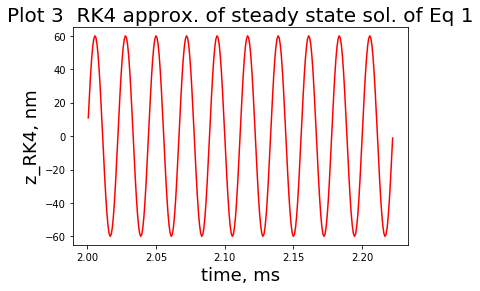

In [8]:
#Definition of v, z, vectors
vdot_RK4 = numpy.zeros(N)
v_RK4 = numpy.zeros(N)
z_RK4 = numpy.zeros(N)
k1v_RK4 = numpy.zeros(N)
k2v_RK4 = numpy.zeros(N)
k3v_RK4 = numpy.zeros(N)
k4v_RK4 = numpy.zeros(N)

k1z_RK4 = numpy.zeros(N)
k2z_RK4 = numpy.zeros(N)
k3z_RK4 = numpy.zeros(N)
k4z_RK4 = numpy.zeros(N)
    
#calculation of velocities RK4

#INITIAL CONDITIONS
v_RK4[0] = 0
z_RK4[0] = 0

   
for i in range (1,N):
       #RK4
        k1z_RK4[i] = v_RK4[i-1]   #k1 Equation 14 
        k1v_RK4[i] = ((   ( -k*z_RK4[i-1] - (m*wo/Q)*v_RK4[i-1] + \
                           Fd*numpy.cos(wo*t[i-1]) )  ) / m )   #m1 Equation 15
        
        k2z_RK4[i] = ((v_RK4[i-1])+k1v_RK4[i]/2.*dt) #k2 Equation 16
        k2v_RK4[i] = ((   ( -k*(z_RK4[i-1]+ k1z_RK4[i]/2.*dt) - (m*wo/Q)*\
                           (v_RK4[i-1] +k1v_RK4[i]/2.*dt) + Fd*\
                           numpy.cos(wo*(t[i-1] + dt/2.)) )  ) / m ) #m2 Eq 17
        
        k3z_RK4[i] = ((v_RK4[i-1])+k2v_RK4[i]/2.*dt) #k3, Equation 18
        k3v_RK4[i] = ((   ( -k*(z_RK4[i-1]+ k2z_RK4[i]/2.*dt) - (m*wo/Q)*\
                            (v_RK4[i-1] +k2v_RK4[i]/2.*dt) + Fd*\
                            numpy.cos(wo*(t[i-1] + dt/2.)) )  ) / m ) #m3, Eq 19
                     
        k4z_RK4[i] = ((v_RK4[i-1])+k3v_RK4[i]*dt) #k4, Equation 20
        k4v_RK4[i] = ((   ( -k*(z_RK4[i-1] + k3z_RK4[i]*dt) - (m*wo/Q)*\
                           (v_RK4[i-1] + k3v_RK4[i]*dt) + Fd*\
                           numpy.cos(wo*(t[i-1] + dt)) )  ) / m )#m4, Eq 21
        
        #Calculation of velocity, Equation 23
        v_RK4[i] = v_RK4[i-1] + 1./6*dt*(k1v_RK4[i] + 2.*k2v_RK4[i] +\
                        2.*k3v_RK4[i] + k4v_RK4[i] )   
        #calculation of position, Equation 22
        z_RK4 [i] = z_RK4[i-1] + 1./6*dt*(k1z_RK4[i] + 2.*k2z_RK4[i] +\
                        2.*k3z_RK4[i] + k4z_RK4[i] ) 

#slicing array to get steady state
z_steady_RK4 = z_RK4[int(90.*period/dt):]
time_steady_RK4 = t[int(90.*period/dt):]
    
plt.title('Plot 3  RK4 approx. of steady state sol. of Eq 1', fontsize=20); 
plt.xlabel('time, ms', fontsize=18);
plt.ylabel('z_RK4, nm', fontsize=18);
plt.plot(time_steady_RK4 *1e3, z_steady_RK4*1e9, 'r-');
plt.ylim(-65,65);
plt.show();

### Error Analysis

Let's plot together our solutions using the different schemes along with our analytical reference.

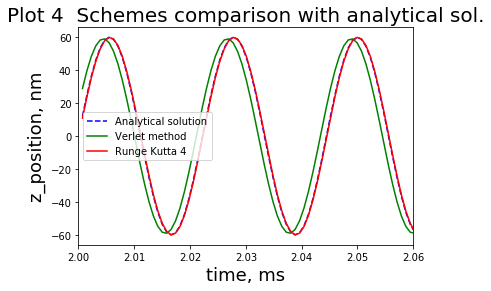

In [9]:
plt.title('Plot 4  Schemes comparison with analytical sol.', fontsize=20);
plt.plot(time_an_steady*1e3, z_an_steady*1e9, 'b--' );
plt.plot(time_steady_V*1e3, z_steady_V*1e9, 'g-' );
plt.plot(time_steady_RK4*1e3, z_steady_RK4*1e9, 'r-');
plt.xlim(2.0, 2.06);
plt.legend(['Analytical solution', 'Verlet method', 'Runge Kutta 4']);
plt.xlabel('time, ms', fontsize=18);
plt.ylabel('z_position, nm', fontsize=18);


It was pointless to include Euler in the last plot because it was not following the physics at all for this given time step. REMEMBER that Euler can give fair approximations, but you MUST decrease the time step in this particular case if you want to see the sinusoidal trajectory!
It seems our different schemes are giving different quality in approximating the solution. However it's hard to conclude something strong based on this qualitative observations. In order to state something stronger we have to perform further error analysis. We will do this at the end of the notebook after the references and will choose L1 norm for this purpose (You can find more information about this [L1](http://en.wikipedia.org/wiki/Taxicab_geometry) ).

As we can see Runge Kutta 4 converges faster than Verlet for the range of time steps studied. And the difference between both is near one order of magnitude. One additional advantage with Runge Kutta 4 is that the method is very stable, even with big time steps (eg. 10 time steps per period) the method is able to catch up the physics of the oscillation, something where Verlet is not so good at.

### Let's add a sample and oscillate our probe over it

It is very common in the field of probe microscopy to model the tip sample interactions through DMT contact mechanics. 
DMT stands for Derjaguin, Muller and Toporov who were the scientists that developed the model (see ref 1). This model uses Hertz contact mechanics (see ref 2) with the addition of long range tip-sample interactions. These long range tip-sample interactions are ascribed to intermolecular interactions between the atoms of the tip and the upper atoms of the surface, and include mainly the contribution of van de Waals forces and Pauli repulsion from electronic clouds when the atoms of the tip meet closely the atoms of the surface. Figure 2 displays a force vs distance curve (FD curve) where it is shown how the forces between the tip and the sample behave with respect to the separation. It can be seen that at positive distances the tip starts "feeling" attraction from the tip (from the contribution of van der Waals forces) where the slope of the curve is positive and at some minimum distance ($a_0$) the tip starts experiencing repulsive interactions arising from electronic cloud repulsion (area where the slope of the curve is negative and the forces are negative). At lower distances, an area known as "contact area" arises and it is characterized by a negative slope and an emerging positive force.

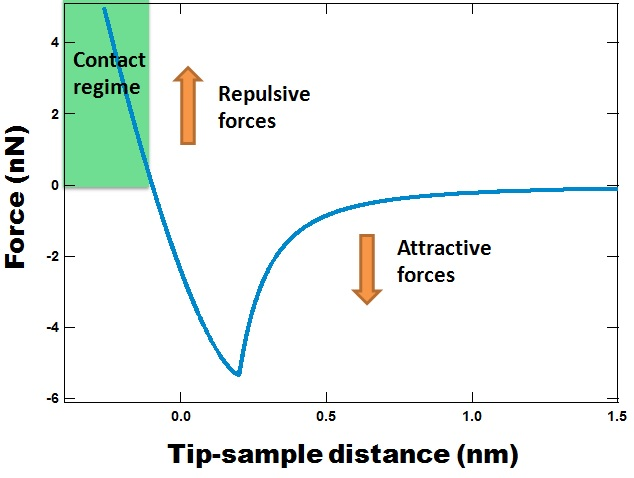

In [10]:
fig3 = path + '/Fig3FDcurve.jpg'
Image(filename=fig3)

### Figure 3.   Force vs Distance profile depicting tip-sample interactions in AFM (Adapted from reference 6)

In Hertz contact mechanics, one central aspect is to consider that the contact area increases as the sphere is pressed against an elastic surface, and this increase of the contact area "modulates" the effective stiffness of the sample. This concept is represented in figure 4 where the sample is depicted as comprised by a series of springs that are activated as the tip goes deeper into the sample. In other words, the deeper the sample goes, the larger the contact area and therefore more springs are activated (see more about this on reference 5). 


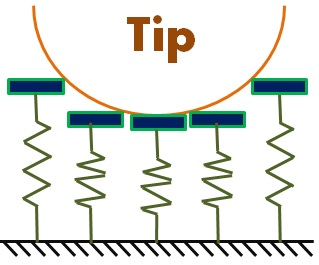

In [11]:
fig4 = path + '/Fig4Hertzspring.jpg'
Image(filename= fig4)

### Figure 4.  Conceptual representation of Hertz contact mechanics

This concept is represented mathematically by a non-linear spring whose elastic coefficient is a function of the contact area which at the same time depends on the sample indentation ( k(d)  ).
$$F_{ts} = k(d)d$$
where
$$k(d) = 4/3E*\sqrt{Rd}$$
being $\sqrt{Rd}$ the contact area when a sphere of radius R indents a half-space to depth d.
$E*$ is the effective Young's modulus of the tip-sample interaction. 

The long range attractive forces are derived using Hamaker's equation (see reference 4): $if$ $d > a_0$
$$F_{ts} = \frac{-HR}{6d^2}$$

where H is the Hamaker constant, R the tip radius and d the tip sample distance. $a_0$ is defined as the intermolecular distance and normally is chosen to be 0.2 nm.

In summary the equations that we will include in our code to take care of the tip sample interactions are the following:

$$\begin{equation}
Fts_{DMT} = \begin{cases} \frac{-HR}{6d^2} \quad \quad d \leq{a_0}\\ \\
\frac{-HR}{6d^2} + 4/3E*R^{1/2}d^{3/2}   \quad \quad d> a_0 \end{cases}
\end{equation}$$

where the effective Young's modulus E* is defined by:
$$\begin{equation}
1/E* = \frac{1-\nu^2}{E_t}+\frac{1-\nu^2}{E_s}
\end{equation}$$
where $E_t$ and $E_s$ are the tip and sample Young's modulus respectively. $\nu_t$ and $\nu_s$ are tip and sample Poisson ratios, respectively.



##### Enough theory, Let's make our code!

Now we will have to solve equation (1) but with the addition of tip-sample interactions which are described by equation (5). So we have a second order non-linear ODE which is no longer analytically straightforward:

$$\begin{equation}
m \frac{d^2z}{dt^2} = - k z - \frac{m\omega_0}{Q}\frac{dz}{dt} + F_0 cos(\omega t) + Fts_{DMT}
\end{equation}$$

Therefore we have to use numerical methods to solve it. RK4 has shown to be more accurate to solve equation (1) among the methods reviewed in the previous section of the notebook, and therefore it is going to be the chosen method to solve equation (6).

Now we have to declare all the variables related to the tip-sample forces. Since we are modeling our tip-sample forces using Hertz contact mechanics with addition of long range Van der Waals forces we have to define the Young's modulus of the tip and sample, the diameter of the tip of our probe, Poisson ratio, etc.

In [12]:
#DMT parameters  (Hertz contact mechanics with long range Van der Waals forces added
a=0.2e-9 #intermolecular parameter
H=6.4e-20 #hamaker constant of sample
R=20e-9 #tip radius of the cantilever
Es=70e6 #elastic modulus of sample
Et=130e9 #elastic modulus of the tip
vt=0.3 #Poisson coefficient for tip
vs=0.3 #Poisson coefficient for sample
E_star= 1/((1-pow(vt,2))/Et+(1-pow(vs,2))/Es)  #Effective Young Modulus

Now let's declare the timestep, the simulation time and let's oscillate our probe!

Text(0.5,1,u'Plot 7   Tip response and driving force')

<Figure size 432x288 with 0 Axes>

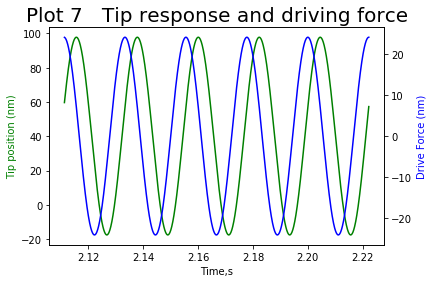

In [13]:
#IMPORTANT distance where you place the probe above the sample
z_base = 40.e-9 

spp = 280. # time steps per period 
dt = period/spp 

simultime = 100.*period
N = int(simultime/dt)
t = numpy.linspace(0,simultime,N)

#Initializing variables for RK4
v_RK4 = numpy.zeros(N)
z_RK4 = numpy.zeros(N)
k1v_RK4 = numpy.zeros(N) 
k2v_RK4 = numpy.zeros(N)
k3v_RK4 = numpy.zeros(N)
k4v_RK4 = numpy.zeros(N)
    
k1z_RK4 = numpy.zeros(N)
k2z_RK4 = numpy.zeros(N)
k3z_RK4 = numpy.zeros(N)
k4z_RK4 = numpy.zeros(N)

TipPos = numpy.zeros(N)
Fts = numpy.zeros(N)
Fcos = numpy.zeros(N)

for i in range(1,N):
   #RK4
    k1z_RK4[i] = v_RK4[i-1]   #k1 Equation 14 
    k1v_RK4[i] = ((   ( -k*z_RK4[i-1] - (m*wo/Q)*v_RK4[i-1] + \
                       Fd*numpy.cos(wo*t[i-1]) +Fts[i-1])  ) / m )   #m1 Equation 15
    
    k2z_RK4[i] = ((v_RK4[i-1])+k1v_RK4[i]/2.*dt) #k2 Equation 16
    k2v_RK4[i] = ((   ( -k*(z_RK4[i-1]+ k1z_RK4[i]/2.*dt) - (m*wo/Q)*\
                       (v_RK4[i-1] +k1v_RK4[i]/2.*dt) + Fd*\
                       numpy.cos(wo*(t[i-1] + dt/2.))  +Fts[i-1])  ) / m )  #m2 Eq 17
    
    k3z_RK4[i] = ((v_RK4[i-1])+k2v_RK4[i]/2.*dt) #k3, Equation 18
    k3v_RK4[i] = ((   ( -k*(z_RK4[i-1]+ k2z_RK4[i]/2.*dt) - (m*wo/Q)*\
                        (v_RK4[i-1] +k2v_RK4[i]/2.*dt) + Fd*\
                        numpy.cos(wo*(t[i-1] + dt/2.))  +Fts[i-1])  ) / m ) #m3, Eq19
                 
    k4z_RK4[i] = ((v_RK4[i-1])+k3v_RK4[i]*dt) #k4, Equation 20
    k4v_RK4[i] = ((   ( -k*(z_RK4[i-1] + k3z_RK4[i]*dt) - (m*wo/Q)*\
                       (v_RK4[i-1] + k3v_RK4[i]*dt) + Fd*\
                       numpy.cos(wo*(t[i-1] + dt))  +Fts[i-1])  ) / m )#m4, Eq 21
    
    #Calculation of velocity, Equation 23
    v_RK4[i] = v_RK4[i-1] + 1./6*dt*(k1v_RK4[i] + 2.*k2v_RK4[i] +\
                    2.*k3v_RK4[i] + k4v_RK4[i] )   
    #calculation of position, Equation 22
    z_RK4 [i] = z_RK4[i-1] + 1./6*dt*(k1z_RK4[i] + 2.*k2z_RK4[i] +\
                     2.*k3z_RK4[i] + k4z_RK4[i] ) 
           
    TipPos[i] = z_base + z_RK4[i] #Adding base position to z position
     
    #calculation of DMT force

    if  TipPos[i] > a: #this defines the attractive regime
        Fts[i] = -H*R/(6*(TipPos[i])**2)
    else:  #this defines the repulsive regime
        Fts[i] = -H*R/(6*a**2)+4./3*E_star*numpy.sqrt(R)*(a-TipPos[i])**1.5
    
          
    Fcos[i] = Fd*numpy.cos(wo*t[i])  #Driving force (this will be helpful to plot the driving force)

#Slicing arrays to get steady state
TipPos_steady = TipPos[int(95*period/dt):] 
t_steady = t[int(95*period/dt):]   
Fcos_steady = Fcos[int(95*period/dt):]   
Fts_steady = Fts[int(95*period/dt):] 

plt.figure(1)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(t_steady*1e3,TipPos_steady*1e9, 'g-')
ax2.plot(t_steady*1e3, Fcos_steady*1e9, 'b-')
ax1.set_xlabel('Time,s')
ax1.set_ylabel('Tip position (nm)', color='g')
ax2.set_ylabel('Drive Force (nm)', color='b')
plt.title('Plot 7   Tip response and driving force', fontsize = 20)


(-20, 30)

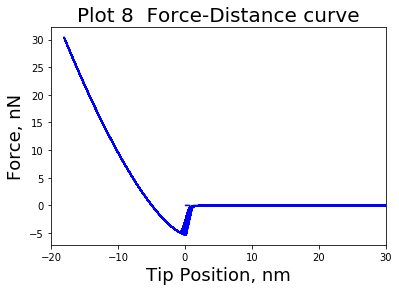

In [14]:
plt.figure(2)
plt.title('Plot 8  Force-Distance curve', fontsize=20)
plt.plot(TipPos*1e9, Fts*1e9, 'b--' )
plt.xlabel('Tip Position, nm', fontsize=18)
plt.ylabel('Force, nN', fontsize=18)
plt.xlim(-20, 30)

Check that we have two sinusoidals. The one in green (the output) is the response signal of the tip (the tip trajectory in time) while the blue one (the input) is the cosinusoidal driving force that we are using to excite the tip. When the tip is excited in free air (without tip sample interactions) the phase lag between the output and the input is 90 degrees. You can test that with the previous code by only changing the position of the base to a high-enough position that it does not interact with the sample. However in the above plot the phase lag is less than 90 degrees. Interestingly the phase can give relative information about the material properties of the sample. There is a well-developed theory of this in tapping mode AFM and it's called phase spectroscopy. If you are interested in this topic you can read reference 1.
Also look at the above plot and see that the response amplitude is no longer 60 nm as we initially set (in this case is near 45 nm!). It means that we have experienced a significant amplitude reduction due to the tip sample interactions.
Besides with the data acquired we are able to plot a Force-curve as the one shown in Figure 3. It shows the attractive and repulsive interactions of our probe with the surface.

We have arrived to the end of the notebook. I hope you have found it interesting and helpful!

REFERENCES

1. Garcı́a, Ricardo, and Ruben Perez. "Dynamic atomic force microscopy methods." Surface science reports 47.6 (2002): 197-301.
2. B. V. Derjaguin, V. M. Muller, and Y. P. Toporov, J. Colloid
Interface Sci. 53, 314  (1975)
3. Hertz, H. R., 1882, Ueber die Beruehrung elastischer Koerper (On Contact Between Elastic Bodies), in Gesammelte Werke (Collected Works), Vol. 1, Leipzig, Germany, 1895.
4. Van Oss, Carel J., Manoj K. Chaudhury, and Robert J. Good. "Interfacial Lifshitz-van der Waals and polar interactions in macroscopic systems." Chemical Reviews 88.6 (1988): 927-941.
5. Enrique A. López-Guerra, and Santiago D. Solares. "Modeling viscoelasticity through spring–dashpot models in intermittent-contact atomic force microscopy." Beilstein journal of nanotechnology 5, no. 1 (2014): 2149-2163.
6. Enrique A. López-Guerra, and Santiago D. Solares, "El microscopio de Fuerza Atómica: Metodos y Aplicaciones." Revista UVG (2013) No. 28, 14-23.

### OPTIONAL: Further error analysis based in norm L1

In [ ]:
print('This cell takes a while to compute')

"""ERROR ANALYSIS EULER, VERLET AND RK4"""

# time-increment array
dt_values = numpy.array([8.0e-7, 2.0e-7, 0.5e-7, 1e-8, 0.1e-8])

# array that will contain solution of each grid
z_values_E = numpy.zeros_like(dt_values, dtype=numpy.ndarray)
z_values_V = numpy.zeros_like(dt_values, dtype=numpy.ndarray)
z_values_RK4 = numpy.zeros_like(dt_values, dtype=numpy.ndarray)
z_values_an = numpy.zeros_like(dt_values, dtype=numpy.ndarray)

for n, dt in enumerate(dt_values):
    simultime = 100*period
    timestep = dt
    N = int(simultime/dt)
    t = numpy.linspace(0.0, simultime, N)
   
    #Initializing variables for Verlet
    zdoubledot_V = numpy.zeros(N)
    zdot_V = numpy.zeros(N)
    z_V = numpy.zeros(N)
    
    #Initializing variables for RK4
    vdot_RK4 = numpy.zeros(N)
    v_RK4 = numpy.zeros(N)
    z_RK4 = numpy.zeros(N)
    k1v_RK4 = numpy.zeros(N) 
    k2v_RK4 = numpy.zeros(N)
    k3v_RK4 = numpy.zeros(N)
    k4v_RK4 = numpy.zeros(N)
    
    k1z_RK4 = numpy.zeros(N)
    k2z_RK4 = numpy.zeros(N)
    k3z_RK4 = numpy.zeros(N)
    k4z_RK4 = numpy.zeros(N)
    
          
    #Initial conditions Verlet (started with Euler approximation)
    z_V[0] = 0.0
    zdot_V[0] = 0.0
    zdoubledot_V[0] = (   ( -k*z_V[0] - (m*wo/Q)*zdot_V[0] + \
                           Fd*numpy.cos(wo*t[0]) )  ) / m
    zdot_V[1] = zdot_V[0] + zdoubledot_V[0]*timestep**2
    z_V[1] = z_V[0] + zdot_V[0]*dt
    zdoubledot_V[1] = (   ( -k*z_V[1] - (m*wo/Q)*zdot_V[1] + \
                           Fd*numpy.cos(wo*t[1]) )  ) / m
    
    
    #Initial conditions Runge Kutta
    v_RK4[1] = 0
    z_RK4[1] = 0 
    
    #Initialization variables for Analytical solution
    z_an = numpy.zeros(N)
       
    # time loop 
    for i in range(2,N):
             
        #Verlet
        z_V[i] = 2*z_V[i-1] - z_V[i-2] + zdoubledot_V[i-1]*dt**2 #Eq 10
        zdot_V[i] = (z_V[i]-z_V[i-2])/(2.0*dt) #Eq 11
        zdoubledot_V[i] = (   ( -k*z_V[i] - (m*wo/Q)*zdot_V[i] +\
                                   Fd*numpy.cos(wo*t[i]) )  ) / m #from eq 1
        
        #RK4
        k1z_RK4[i] = v_RK4[i-1]   #k1 Equation 14 
        k1v_RK4[i] = ((   ( -k*z_RK4[i-1] - (m*wo/Q)*v_RK4[i-1] + \
                           Fd*numpy.cos(wo*t[i-1]) )  ) / m )   #m1 Equation 15
        
        k2z_RK4[i] = ((v_RK4[i-1])+k1v_RK4[i]/2.*dt) #k2 Equation 16
        k2v_RK4[i] = ((   ( -k*(z_RK4[i-1]+ k1z_RK4[i]/2.*dt) - (m*wo/Q)*\
                           (v_RK4[i-1] +k1v_RK4[i]/2.*dt) + Fd*\
                           numpy.cos(wo*(t[i-1] + dt/2.)) )  ) / m )  #m2 Eq 17
        
        k3z_RK4[i] = ((v_RK4[i-1])+k2v_RK4[i]/2.*dt) #k3, Equation 18
        k3v_RK4[i] = ((   ( -k*(z_RK4[i-1]+ k2z_RK4[i]/2.*dt) - (m*wo/Q)*\
                            (v_RK4[i-1] +k2v_RK4[i]/2.*dt) + Fd*\
                            numpy.cos(wo*(t[i-1] + dt/2.)) )  ) / m ) #m3, Eq 19
                     
        k4z_RK4[i] = ((v_RK4[i-1])+k3v_RK4[i]*dt) #k4, Equation 20
        k4v_RK4[i] = ((   ( -k*(z_RK4[i-1] + k3z_RK4[i]*dt) - (m*wo/Q)*\
                           (v_RK4[i-1] + k3v_RK4[i]*dt) + Fd*\
                           numpy.cos(wo*(t[i-1] + dt)) )  ) / m )#m4, Equation 21
        
        #Calculation of velocity, Equation 23
        v_RK4[i] = v_RK4[i-1] + 1./6*dt*(k1v_RK4[i] + 2.*k2v_RK4[i] +\
                        2.*k3v_RK4[i] + k4v_RK4[i] )   
        #calculation of position, Equation 22
        z_RK4 [i] = z_RK4[i-1] + 1./6*dt*(k1z_RK4[i] + 2.*k2z_RK4[i] +\
                         2.*k3z_RK4[i] + k4z_RK4[i] ) 

             
        #Analytical solution
        A_an = Fo_an*Q/k  #when driven at resonance A is simply Fo*Q/k
        phi = numpy.pi/2  #when driven at resonance the phase is pi/2
        z_an[i] = A_an*numpy.cos(wo*t[i] - phi)  #Analytical solution eq. 1
    
          
    #Slicing the full response vector to get the steady state response
    z_steady_V = z_V[int(80*period/timestep):]
    z_an_steady = z_an[int(80*period/timestep):]
    z_steady_RK4 = z_RK4[int(80*period/timestep):]
    time_steady = t[int(80*period/timestep):]
    
    z_values_V[n] = z_steady_V.copy()  # error for certain value of timestep
    z_values_RK4[n] = z_steady_RK4.copy() #error for certain value of timestep
    z_values_an[n] = z_an_steady.copy()  #error for certain value of timestep


def get_error(z, z_exact, dt):
    #Returns the error with respect to the analytical solution using L1 norm
       
    return dt * numpy.sum(numpy.abs(z-z_exact))
    
#NOW CALCULATE THE ERROR FOR EACH RESPECTIVE DELTA T
error_values_V = numpy.zeros_like(dt_values)
error_values_RK4 = numpy.zeros_like(dt_values)

for i, dt in enumerate(dt_values):
    ### call the function get_error() ###
    error_values_V[i] = get_error(z_values_V[i], z_values_an[i], dt)
    error_values_RK4[i] = get_error(z_values_RK4[i], z_values_an[i], dt)


plt.figure(1)
plt.title('Plot 5  Error analysis Verlet based on L1 norm', fontsize=20)
plt.tick_params(axis='both', labelsize=14)
plt.grid(True)                         #turn on grid lines
plt.xlabel('$\Delta t$ Verlet', fontsize=16)  #x label
plt.ylabel('Error Verlet', fontsize=16)       #y label
plt.loglog(dt_values, error_values_V, 'go-')  #log-log plot
plt.axis('equal')                      #make axes scale equally;

plt.figure(2)
plt.title('Plot 6  Error analysis RK4 based on L1 norm', fontsize=20) 
plt.tick_params(axis='both', labelsize=14) 
plt.grid(True)     #turn on grid lines
plt.xlabel('$\Delta t$ RK4', fontsize=16)  #x label
plt.ylabel('Error RK4', fontsize=16)       #y label
plt.loglog(dt_values, error_values_RK4,  'co-')  #log-log plot
plt.axis('equal')                      #make axes scale equally;